In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_dataset(path):
    data = load_files(path)
    plant_files = np.array(data['filenames'])
    plant_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return plant_files, plant_targets

In [3]:
train_files, train_targets = load_dataset('plant_images/train')
valid_files, valid_targets = load_dataset('plant_images/valid')
test_files, test_targets = load_dataset('plant_images/test')

In [5]:
plant_names = [item[19:-1] for item in sorted(glob("plant_images/train/*/"))]
print(plant_names)

['SpeciesA', 'SpeciesB', 'SpeciesC']


In [6]:
print('There are %d total plant categories.' % len(plant_names))
print('There are %s total plant images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training plant images.' % len(train_files))
print('There are %d testing pnat images.' % len(test_files))
print('There are %d validation plant images.' % len(valid_files))

There are 3 total plant categories.
There are 681 total plant images.

There are 422 training plant images.
There are 62 testing pnat images.
There are 197 validation plant images.


In [7]:
def plots(ims,figsize=(10,6),rows=1,interp=False,titles=None):
    if type(ims[0]) is np.ndarray:
        ins=np.array(ims).astype(np.uint8)
        if (ims.shape[-1] !=3):
            ims=ims.transpose((0,2,3,1))
    f=plt.figure(figsize=figsize)
    cols=len(ims)//rows if len(ims)%2 ==0 else len(ims)//rows
    for i in range(len(ims)):
        sp=f.add_subplot(rows,cols,i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=10)
        plt.imshow(ims[i],interpolation=None)

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [10]:
from PIL import ImageFile 
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

print(train_tensors.shape)

100%|██████████| 62/62 [00:22<00:00,  3.29it/s]

(422, 224, 224, 3)


TypeError: Image data can not convert to float

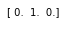

In [13]:
imgs=train_files
labels=train_targets
plots(imgs,titles=labels)

In [14]:
from keras.layers import Conv2D, Dropout, Flatten, Dense, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential

In [15]:
model=Sequential()
model.add(Conv2D(filters=64,kernel_size=3, input_shape=(224,224,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.2))

model.add(Conv2D(filters=512,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.2))

model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.2))

model.add(Conv2D(filters=512,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.1))

model.add(Conv2D(filters=1024,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.1))

#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(.1))
model.add(Dense(3,activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 512)     295424    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 512)       0         
_________________________________________________________________
dropout_2 (Dropout)  

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [17]:
from keras.callbacks import ModelCheckpoint
import h5py
from keras.preprocessing.image import ImageDataGenerator

In [17]:
'''
train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)
valid_datagen=ImageDataGenerator(rescale=1./255)
train_set=train_datagen.fit(train_)
test_set=test_datagen.fit(test_files)
valid_set=valid_datagen.fit(valid_files)
'''

'\ntrain_datagen=ImageDataGenerator(rescale=1./255)\ntest_datagen=ImageDataGenerator(rescale=1./255)\nvalid_datagen=ImageDataGenerator(rescale=1./255)\ntrain_set=train_datagen.fit(train_)\ntest_set=test_datagen.fit(test_files)\nvalid_set=valid_datagen.fit(valid_files)\n'

In [18]:
checkpoint_filepath = 'weights.best.my.hdf5'

my_checkpointer = ModelCheckpoint(filepath=checkpoint_filepath,
                               verbose=1, save_best_only=True)

history=model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=10, batch_size=10, callbacks=[my_checkpointer], verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 422 samples, validate on 197 samples
Epoch 1/10
422/422 [==============================] - 239s 566ms/step - loss: 10.3918 - acc: 0.3389 - val_loss: 10.5545 - val_acc: 0.3452

Epoch 00001: val_loss improved from inf to 10.55449, saving model to weights.best.my.hdf5
Epoch 2/10
422/422 [==============================] - 289s 684ms/step - loss: 10.8091 - acc: 0.3294 - val_loss: 10.5545 - val_acc: 0.3452

Epoch 00002: val_loss did not improve from 10.55449
Epoch 3/10
422/422 [==============================] - 162s 384ms/step - loss: 10.7327 - acc: 0.3341 - val_loss: 10.5545 - val_acc: 0.3452

Epoch 00003: val_loss did not improve from 10.55449
Epoch 4/10
422/422 [==============================] - 156s 370ms/step - loss: 10.7709 - acc: 0.3318 - val_loss: 10.5545 - val_acc: 0.3452

Epoch 00004: val_loss did not improve from 10.55449
Epoch 5/10
422/422 [==============================] - 160s 379ms/step - loss: 10.6181 - acc: 0.3412 - va

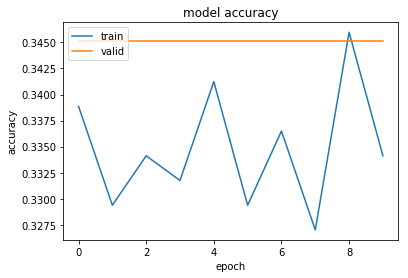

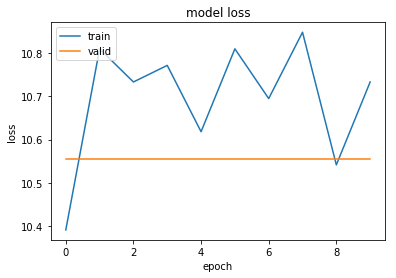

In [19]:
model.load_weights(checkpoint_filepath)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [21]:
pred=[model.predict(np.expand_dims(feature, axis=0)) for feature in test_tensors]

In [22]:
pred

[array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=float32),
 array([[ 0.,  1.,  0.]], dtype=fl